### Brinson Attribution Model


Yan Wu</br>
yanwu26@gmail.com

After you've constructed your portfolio, and managed to your active risk goals, you'll need to measure the sources of returns versus the benchmark. The most common model is the Brinson Attribution Three Factor Model. The general breakdown is below:

1) **Allocation** - Did we pick the right sectors<br/>
We may have outperformed the benchmark but the source of returns came from simply being overweight a particular sector.

2) **Selection** - Did we pick the right sectors<br/>
We may have picked the right sector (Tech in 2015) but selected the wrong stocks (Yahoo in 2015). 

3) **Interaction** - Did we over/underweight the stocks we chose <br/>
We need to pick the right stock and sector, but also take on more active risk. For example, if TSLA had an excess return of 10%, but we underweighed the benchmark, we would show a negative interaction effect.

**Honestly, what is this interaction effect?**<br/>
Most people grasp allocation and selection effect, but have a hard time understanding interaction effect. Some people even wonder if it's useful to show. My answer is as follows: **it depends!**

If the manager is an allocation manager (IE they focus on picking right sectors, countries) then you could roll it into selection. If the manager is a stock picker, then you can roll it into selection effect.

I won't go into the math but there are plenty of documentation out for the Brinson model. See below for an example

https://corporate.morningstar.com/us/documents/MethodologyDocuments/MethodologyPapers/EquityPerformanceAttributionMeth.pdf

In [4]:
# Required python package imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import time 
import multiprocessing 
import matplotlib.image as image
import datetime
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
params = {'legend.fontsize': 'x-large','figure.figsize': (15, 5),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Load Holdings Data

In [5]:
def get_hld_data():
    df=pd.read_csv('C:/Users/ywu/Google Drive/Working Folder/public_code/python/Data/brinson_example.csv')
    df['asof_dt']=pd.to_datetime(df['asof_dt'].astype(str), format='%m/%d/%Y')
    df['ret_con_p']=df['ret']*df['w_p'] #calculate contribution to return in portfolio
    df['ret_con_bm']=df['ret']*df['w_bm'] #calculate contribution return in benchmark
    return df

### Calculate all attributes needed to calculate attribution

In [10]:
# Calculate total return of portfolkio and benchmark
def get_daily_ret(df):
    #calculate portfolio return
    df1=pd.DataFrame(df.groupby(['asof_dt'])['ret_con_p'].sum()).reset_index()
    df1.columns=['asof_dt','ret_p']
    #calculate benchmark return
    df2=pd.DataFrame(df.groupby(['asof_dt'])['ret_con_bm'].sum()).reset_index()
    df2.columns=['asof_dt','ret_bm']
    #merge and then calculate total return
    df_tot=pd.merge(df1,df2,on='asof_dt')
    df_tot['ret_a']=df_tot['ret_p']-df_tot['ret_bm']
    return df_tot
# Calculate country level return, and contribution to return, in Benchmark and Portfolio
def get_sec_ret(df): 
    df1=pd.DataFrame(df.groupby(['asof_dt','Sector'])['ret_con_p'].sum()/df.groupby(['asof_dt','Sector'])['w_p'].sum())
    df2=pd.DataFrame(df.groupby(['asof_dt','Sector'])['ret_con_bm'].sum()/df.groupby(['asof_dt','Sector'])['w_bm'].sum())
    df3=pd.DataFrame(df.groupby(['asof_dt','Sector'])['ret_con_p'].sum())
    df4=pd.DataFrame(df.groupby(['asof_dt','Sector'])['ret_con_bm'].sum())
    df_tot=pd.concat([df1,df2,df3,df4], axis=1)
    df_tot.columns=['ret_sec_p','ret_sec_bm','ret_con_p','ret_con_bm']
    df_tot=df_tot.reset_index()
    return df_tot
#calculate sector level weights
def get_sec_wgt(df):
    return df.groupby(['asof_dt','Sector'])[['asof_dt','Sector','w_p','w_bm']].sum().reset_index()
#get all data together
def get_data_prepped():
    df_raw=get_hld_data()
    df1=pd.merge(get_daily_ret(df_raw),get_sec_ret(df_raw), on='asof_dt')
    df2=pd.merge(df1,get_sec_wgt(df_raw), on=['asof_dt','Sector'])
    return df_raw, df2

### Calculate attribution by Sector and by day

In [7]:
def get_attribution(df):
    df['allocation']=(df['ret_sec_bm'])*(df['w_p']-df['w_bm'])
    df['selection']=(df['ret_sec_p']-df['ret_sec_bm'])*(df['w_bm'])
    df['interaction']=(df['ret_sec_p']-df['ret_sec_bm'])*(df['w_p']-df['w_bm'])
    df['tot']=df['allocation']+df['selection']+df['interaction']
    df=df[['asof_dt','Sector','ret_p','ret_bm','ret_a','w_p','w_bm','ret_sec_p','ret_sec_bm','ret_con_p','ret_con_bm',
       'allocation','selection','interaction','tot']]
    # aggregate some by SUM, some by Mean
    # daily attribution:
    agg={'w_p':'sum','w_bm':'sum','ret_sec_p':'sum','ret_sec_bm':'sum','ret_con_p':'sum','ret_con_bm':'sum',
    'ret_p':'mean','ret_bm':'mean','ret_a':'mean','allocation':'sum','selection':'sum','interaction':'sum','tot':'sum'}
    df_daily=df.groupby('asof_dt').agg(agg).reset_index()
    df_daily=df_daily[['asof_dt','allocation','selection','interaction','tot','w_p','w_bm','ret_p','ret_bm','ret_a']]
    return df, df_daily

### Calcuate coefficients for carino linkage

In [18]:
def calc_sectors_periods():
    ##Calculate coefficients
    # first get the values
    df_raw, df=get_data_prepped() #get raw data, get prepared data
    df_sec, df_daily=get_attribution(df) #get sector attribution, get daily total attribution
    ret_p, ret_bm = df_daily['ret_p'], df_daily['ret_bm']
    tot_p, tot_bm = np.product(1+ret_p.values)-1, np.product(1+ret_bm.values)-1
    # then transform into natural log
    coef_daily=np.array((np.log(1+ret_p)-np.log(1+ret_bm))/(ret_p-ret_bm))
    coef_tot=(np.log(1+tot_p)-np.log(1+tot_bm))/(tot_p-tot_bm)
    ## Calculate total coefficients for sector returns
    ls=set(df_sec['Sector'])
    k=[]
    for n in ls:
        d=np.array(df_sec[df_sec['Sector']==n][['allocation','selection','interaction']]).T.dot(coef_daily)/coef_tot
        k.append(d)
    df_attr_tot=pd.DataFrame(k,index=ls, columns=['allocation','selection','interaction']) #turn array into dataframe, add headers and rows
    df_attr_tot['Total']=df_attr_tot['allocation']+df_attr_tot['selection']+df_attr_tot['interaction']
    df_attr_tot=pd.concat([df_attr_tot,pd.DataFrame(df_attr_tot.sum(axis=0),columns=['Grand Total']).T])
    return df_sec, df_daily, df_attr_tot, coef_tot, coef_daily

In [19]:
df_sec, df_daily, df_attr_tot, coef_tot, coef_daily = calc_sectors_periods()
df_sec=df_sec[['asof_dt','Sector','allocation','selection','interaction','tot']]
df_plot=df_daily[['asof_dt','allocation','selection','interaction','tot']].set_index('asof_dt')

In [21]:
coef_daily

array([ 1.01432825,  0.98093725,  0.99261045,  0.99493827,  1.00773522,
        1.00128573,  0.97619225,  1.00670977,  1.00435137,  0.98690738,
        0.9891777 ,  0.98442377,  0.98305726,  1.00844994,  1.00547067,
        0.99557028,  1.01040753,  1.01151196,  0.98959129,  0.99149236,
        1.00349677,  1.01158143,  1.02841719,  1.00922487,  1.01212198,
        0.98095315,  0.98771961,  0.98261924,  0.98455389,  1.00610243,
        0.99476179,  1.01910466,  1.0102163 ,  0.99468098,  1.01347969,
        1.00324133,  1.00480281,  1.02082907,  1.01523579,  0.99092345,
        0.97424872,  0.98351556,  1.03519913,  0.98684473,  1.01430652,
        0.98490487,  0.99326988,  0.98734833,  0.99174981,  0.98802455,
        1.01960902,  0.98676416,  0.99933052,  1.0077683 ,  0.99181721,
        0.99696793,  0.98055975,  1.02230584,  1.00257032,  0.99663861,
        0.99161533,  1.01752421,  1.00979366,  0.99161063,  1.01698607,
        1.00313963,  0.99154942,  1.00061254,  0.99018349,  1.01

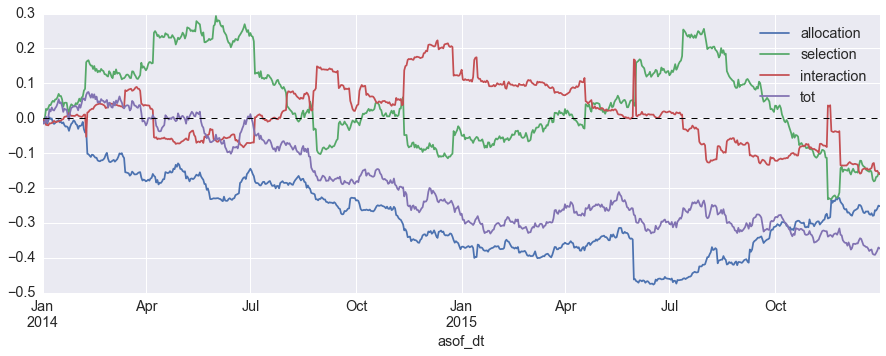

In [21]:
ax=(np.cumprod(df_plot['allocation']+1)-1).plot()
ax=(np.cumprod(df_plot['selection']+1)-1).plot()
ax=(np.cumprod(df_plot['interaction']+1)-1).plot()
ax=(np.cumprod(df_plot['tot']+1)-1).plot()
plt.axhline(0,color='k', ls='dashed', lw=1)
ax.legend();

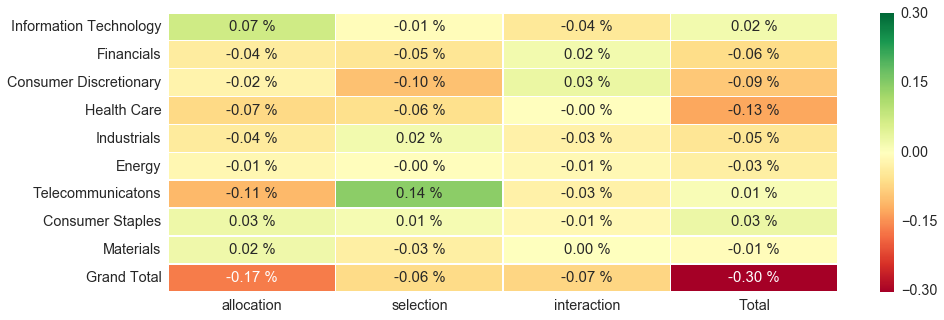

In [17]:
#sns.palplot(sns.color_palette("RdYlGn", 20))
ax=sns.heatmap(df_attr_tot, annot=True, linewidths=.5, fmt='.2f', cmap='RdYlGn',annot_kws={"size": 15})
for t in ax.texts: t.set_text(t.get_text() + " %")

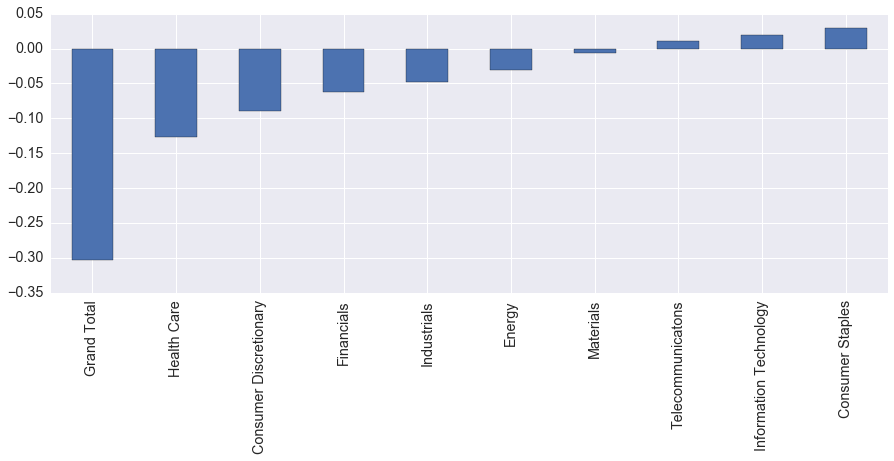

In [175]:
df_attr_tot.Total.sort_values().plot(kind='bar')

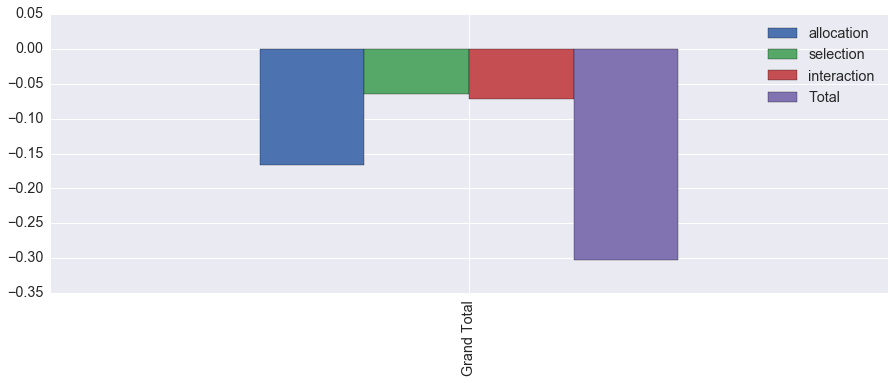

In [172]:
ax1=df_attr_tot[df_attr_tot.index=='Grand Total'].plot(kind='bar')
ax1.label_outer()